In [1]:
from xmlrpc.client import _datetime_type

import matplotlib.pyplot as plt
import numpy as np
import math
import cmath

__Propogation matrix function__

In [2]:
## matrix which describes propagation of light within layer 
## k_x - wavenumber along x; d - thickness of layer; 
## epsilon - dielectric constant of the layer; k_0 - wavenumber in vaccum
def t_propogation(k_0, k_x, d, epsilon):
    k_z = (k_0**2*epsilon - k_x**2)**(1./2)
    T = np.zeros((2,2), dtype=np.complex128)
    T[0][0] = np.exp(1j*k_z*d)
    T[1][1] = np.exp(-1j*k_z*d)
    return T

__Interface matrix function__

In [3]:
## matrix which describes boundary conditions on the interface; 
## e_1 - dielectric constant of layer from which light incident, 
## e_2 - dielectric constant of the second layer
def t_interface(polarization, e_1, e_2, k_x, k_0):
    k_z_1 = (k_0 ** 2 * e_1 - k_x ** 2)**(1/2)
    k_z_2 = (k_0 ** 2 * e_2 - k_x ** 2)**(1/2)
    F_1 = np.ones((2,2), dtype=np.complex128)
    F_2 = np.ones((2,2), dtype=np.complex128)
    if polarization == 1: # s-polarization
        F_1[1][0] = -k_z_1/k_0
        F_1[1][1] = k_z_1/k_0
        F_2[1][0] = -k_z_2 / k_0
        F_2[1][1] = k_z_2 / k_0
    else:                 # p-polarization
        F_1[0][0] = k_z_1/(k_0 * e_1)
        F_1[0][1] = k_z_1/(k_0 * e_1)
        F_1[1][1] = -1
        F_2[0][0] = k_z_2 / (k_0 * e_2)
        F_2[0][1] = k_z_2 / (k_0 * e_2)
        F_2[1][1] = -1
    F = np.zeros((2,2), dtype=np.complex128)
    inverse_F_2 = np.linalg.inv(F_2)
    F = inverse_F_2 @ F_1
    return F

__Considered incident angles__

In [4]:
theta = np.linspace(1, 89, 300) # incident angles

__Considering wavelength range (integer number in nm) and frequency range (in eV)__

In [6]:
Wavelength = open('Wavelength.txt', 'r') # list of considering wavelength in nm

In [7]:
wavelength_range = []
frequency_range = []
for line in Wavelength:
    a = int(line)
    wavelength_range.append(a)
    b = 1240/a
    frequency_range.append(b)

In [8]:
Wavelength.close()

__Dielectric constant of the prism__

In [9]:
e_prism = [4 + 0j, 9 + 0j, 16 + 0j]

__Thickness of the gold (in nm)__

In [10]:
gold_thickness = [30, 40, 50]

__Dispersion of gold (using the same wavelength as in wavelength section)__

In [14]:
# Tabulated dispersion
# first column - wavelength (integer in nm)
# second column - e1
# third column - e2
Dispersion_gold = open('Dispersion_gold.txt', 'r')
gold_disp = []
for line in Dispersion_gold:
    wavelength, epsilon_1, epsilon_2 = line.split()
    wavelength = int(wavelength)
    epsilon_1 = float(epsilon_1)
    epsilon_2 = float(epsilon_2)
    epsilon = complex(epsilon_1, epsilon_2)
    gold_disp.append(epsilon)
Dispersion_gold.close()

__Dispersion of MoS$_2$ (using the same wavelength as in wavelength section)__

In [16]:
# Tabulated dispersion
# first column - wavelength (integer in nm)
# second column - e1
# third column - e2
Dispersion_MoS_2 = open('Dispersion_MoS2.txt', 'r')
mos2_disp = []
for line in Dispersion_MoS_2:
    wavelength, epsilon_1, epsilon_2 = line.split()
    wavelength = int(wavelength)
    epsilon_1 = float(epsilon_1)
    epsilon_2 = float(epsilon_2)
    epsilon = complex(epsilon_1, epsilon_2)
    mos2_disp.append(epsilon)
Dispersion_MoS_2.close()

__n_Prism = 2 and gold thickness = 30 nm__ 

In [17]:
#reflection = np.zeros((len(wavelength_range), len(theta))) 
reflection = np.zeros((len(theta), len(wavelength_range)))
# list of reflection coefficient for 2 parameters 4: theta; 5: photon energy in eV

__Calculation of reflection__

In [18]:
e = e_prism[0] # refractive index of prism, in future we will make iteration
t = gold_thickness[0] # thickness of gold in future we will make iterations

pol = 0 # 0 - p-polarization; consider only this polarization because s-polarization cann't induce plasmon polariton
    
for i in range(len(wavelength_range)):
        
    wavelength = wavelength_range[i]
    k_0 = 2*np.pi/wavelength
        
    for j in range(len(theta)):
            
        angle = theta[j]
            
        k_x = k_0*np.sin(np.pi*angle/180)*e**(1/2)
            
        e_gold = gold_disp[i]
        e_mos2 = mos2_disp[i]
            
        T = np.array([[1, 0], [0, 1]]) # initialize transfer matrix
        T = t_interface(pol, e, e_gold, k_x, k_0) @ T # prism-gold interface
        T = t_propogation(k_0, k_x, t, e_gold) @ T # propagation in gold
        T = t_interface(pol, e_gold, e_mos2, k_x, k_0) @ T # gold-mos2 interface
        T = t_propogation(k_0, k_x, 0.73, e_mos2) @ T # propogation in mos2
        T = t_interface(pol, e_mos2, 1, k_x, k_0) @ T # mos2-air interface
            
        R = abs(T[1][0]/T[1][1])**2
            
        reflection[j][i] += R

__Plot results__

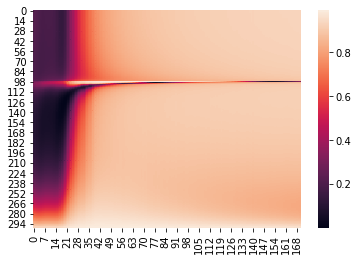

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
import seaborn as sb

x = frequency_range
y = theta

x, y = np.meshgrid(x, y)

z = reflection

ax = sb.heatmap(z)
# ax.invert_yaxis()

In [20]:
for i in range(len(theta)):
    print(reflection[i][15])

0.16479494510800122
0.16478496802807435
0.16477247874187323
0.16475750975590941
0.16474010031222916
0.1647202964439004
0.16469815104056404
0.16467372392435406
0.1646470819365602
0.16461829903545094
0.164587456405736
0.16455464258021052
0.16451995357418567
0.16448349303338752
0.16444537239607562
0.16440571107022
0.1643646366266632
0.16432228500929372
0.1642788007633572
0.16423433728316272
0.1641890570805453
0.16414313207561604
0.16409674391145745
0.1640500842946115
0.16400335536338623
0.16395677008622253
0.16391055269258348
0.16386493913910083
0.1638201776139853
0.16377652908303858
0.1637342678809521
0.1636936823519866
0.16365507554456865
0.16361876596484543
0.16358508839480568
0.16355439478121694
0.16352705520233735
0.163503458920203
0.16348401552717812
0.16346915619654911
0.16345933504810117
0.16345503064100692
0.16345674760790194
0.16346501844580746
0.16348040548161996
0.1635035030322294
0.16353493978206404
0.16357538140399283
0.1636255334531679
0.1636861445676223
0.1637580100143826


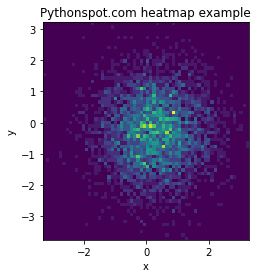

In [21]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
 
# Create data
x = np.random.randn(4096)
y = np.random.randn(4096)
 
# Create heatmap
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(64,64))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
 
# Plot heatmap
plt.clf()
plt.title('Pythonspot.com heatmap example')
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap, extent=extent)
plt.show()